In [ ]:
# default_exp metrics

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Metrics

> Metrics to evaluate time-series.

Mostly copied from <https://github.com/MSRDL/Deep4Cast>

In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *


In [ ]:
# export

def mape(truth, pred, reduction='mean') -> tensor:
    """Computes mean absolute percentage error (MAPE)
    """
    norm = torch.abs(truth)
    ret= torch.div(torch.abs(pred - truth), norm)     
    
    if reduction != 'none':
        ret = torch.mean(ret) if reduction == 'mean' else torch.sum(ret)    
    return ret

In [ ]:
# hide
output = torch.sigmoid(torch.randn(32, 100,requires_grad=True))
target = torch.randint(0,2,(32, 100)).float()
test_eq(mape(output,target).shape,[])
test_eq(mape(output,target,reduction='mean').shape,[])
test_eq(mape(output,target,reduction='sum').shape,[])
test_eq(mape(output,target,reduction='none').shape,[32,100])

In [ ]:
def np_smape(a, b):
    """
    Calculates sMAPE
    :param a: actual values
    :param b: predicted values
    :return: sMAPE
    """
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return np.mean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b) + 1e-16))   # BT changed 2 to 200

In [ ]:
def torch_smape(model_outputs,target_outputs):
    numerator = torch.abs(model_outputs - target_outputs)
    denominator = torch.abs(model_outputs) + torch.abs(target_outputs)
    elementwise_smape = 2*torch.div(numerator, denominator)
    nan_mask = torch.isnan(elementwise_smape)
    loss = elementwise_smape[~nan_mask].mean()    
    assert ~torch.isnan(loss)
    return loss

In [ ]:
# export
def smape(truth, pred, agg=None, reduction='mean') -> tensor:
    """Computes symmetric mean absolute percentage error (SMAPE) on the mean
    
    Arguments:
        * data_samples (``np.array``): Sampled predictions (n_timeseries, n_variables, n_timesteps).
        * data_truth (``np.array``): Ground truth time series values (n_timeseries, n_variables, n_timesteps).
        * agg: Aggregation function applied to sampled predictions (defaults to ``np.median``).
    """
    if pred.shape != truth.shape:
        raise ValueError('Last three dimensions of data_samples and data_truth need to be compatible')
        
    eps = 1e-16  # Need to make sure that denominator is not zero
    norm = (torch.abs(pred) + torch.abs(truth)) + eps
    ret = (2.0 * torch.abs(pred - truth) / norm)
    
    if reduction != 'none':
        ret = torch.mean(ret) if reduction == 'mean' else torch.sum(ret)
    return ret

def SMAPELossFlat(*args, axis=-1, floatify=True, **kwargs):
    """Same as `smape`, but flattens input and target.
    DOES not work yet
    """
    return BaseLoss(smape, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [ ]:
# hide
output = torch.sigmoid(torch.randn(32, 100,requires_grad=True))
target = torch.randint(0,2,(32, 100)).float()
test_eq(smape(output,target).shape,[])
test_eq(smape(output,target,reduction='mean').shape,[])
test_eq(smape(output,target,reduction='sum').shape,[])
test_eq(smape(output,target,reduction='none').shape,[32,100])

In [ ]:
# hide
test_eq(F.mse_loss(output,target).shape,[])
test_eq(F.mse_loss(output,target,reduction='mean').shape,[])
test_eq(F.mse_loss(output,target,reduction='sum').shape,[])
test_eq(F.mse_loss(output,target,reduction='none').shape,[32,100])

In [ ]:
# hide
for l in [100,10]:
    res={}
    for er in np.arange(.5,1.5,.05):
        res[er] = {}
        noise,y = torch.randn(64,1,l) * er, torch.cat([torch.arange(-(l/2),(l/2))[None,None,:]]*64,0)
        y_hat = y + noise
        smp = 0
        for i in range(64):
             smp += np_smape(y[i,:].numpy(),y_hat[i,:].numpy()) 
                
        test_close(smape(y,y_hat, reduction='sum').numpy(), l*smp,.02)
        test_close(smape(y,y_hat, reduction='mean'), torch_smape(y,y_hat))
        test_eq(smape(y,y_hat, reduction='mean').shape,())

y_hat: 0.7032093405723572
y_hat2:1.0056021213531494


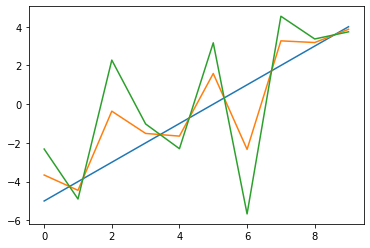

In [ ]:
y_hat2 = noise + y_hat
plt.plot(np.arange(10),y[0,0])
plt.plot(np.arange(10),y_hat[0,0])
plt.plot(np.arange(10),y_hat2[0,0])
print(f"y_hat: {smape(y,y_hat,reduction='mean')}")
print(f"y_hat2:{smape(y,y_hat2,reduction='mean')}")

In [ ]:
# hide
test_eq(smape(y,y_hat,reduction='mean')<smape(y,y_hat2,reduction='mean'),True)

In [ ]:
def np_mase(y_test, y_hat_test,insample, freq):
    """
    Calculates MAsE
    :param insample: insample data
    :param y_test: out of sample target values
    :param y_hat_test: predicted values
    :param freq: data frequency
    :return:
    """
    y_hat_naive = []
    for i in range(freq, len(insample)):
        y_hat_naive.append(insample[(i - freq)])
    
    masep = np.mean(abs(insample[freq:] - y_hat_naive))
    return np.mean(abs(y_test - y_hat_test)) / masep


In [ ]:
# export

def mase(y_test, y_hat_test, insample, freq, reduction=None):
    """Computes mean absolute scaled error (MASE) as in the `M4 competition
    <https://www.m4.unic.ac.cy/wp-content/uploads/2018/03/M4-Competitors-Guide.pdf>`_.
    Arguments:
        * 
        
    """    
    eps = 1e-16  # Need to make sure that denominator is not zero
    # Calculate mean absolute for forecast and naive forecast per time series   
    err = torch.abs(y_test - y_hat_test)
    
    naive_forecast = insample[:, :-freq]
    naive_target = insample[:, freq:]
    naive_err = torch.abs(naive_target - naive_forecast).mean(-1)[:,None]
    ret = torch.div(err, naive_err+eps).mean(-1)
    if reduction is not None:
        ret = torch.mean(ret,-1) if reduction == 'mean' else torch.sum(ret,-1)
    return ret 



In [ ]:
# hide
for l in [114, 1014]:
    res={}
    horizon = 14
    for er in np.arange(.5,1.5,.05):
        res[er] = {}
        noise,x = torch.randn(64, 1, l) * er, torch.cat([torch.arange(-(l/2),(l/2))[None,None,:]] * 64,0)
        y_hat = x + noise      
        y = x
        smp = 0
        for i in range(64):
            smp += np_mase(x[i, 0, -horizon:].numpy(), y_hat[i, 0, -horizon:].numpy(), x[i, 0, :-horizon].numpy(), 7)
        
        my = mase( x[:, 0, -horizon:], y_hat[:, 0, -horizon:],x[:, 0, :-horizon], 7, reduction = 'sum')
        test_close(my, smp)
        test_eq(mase(x[:, 0, -horizon:], y_hat[:, 0, -horizon:],x[:, 0, :-horizon], 7, reduction = 'mean').shape,())


y_hat: 0.11644293367862701
y_hat2:0.23288586735725403


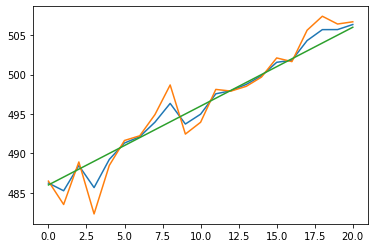

In [ ]:
y_hat2=noise + y_hat
plt.plot(np.arange(21),y_hat[0,0,-21:])
plt.plot(np.arange(21),y_hat2[0,0,-21:])
plt.plot(np.arange(21),y[0,0,-21:])
err_y_hat =  mase(x[0, 0, -horizon:][None,:], y_hat [0, 0, -horizon:][None,:], x[0, 0, :-horizon][None,:], 7, reduction = 'mean')
err_y_hat2 = mase(x[0, 0, -horizon:][None,:], y_hat2[0, 0, -horizon:][None,:],x[0, 0, :-horizon][None,:], 7, reduction = 'mean')
print(f"y_hat: {err_y_hat}")
print(f"y_hat2:{err_y_hat2}")

In [ ]:
# hide
test_eq(err_y_hat<err_y_hat2, True)

In [ ]:
# export
class MASE(Module):
    def __init__(self, freq, *args, **kwargs):
        self.freq = freq 
        self.x_sample = None
        
    def forward(self, inp, targ, **kwargs):
        assert self.x_sample is not None, f"Please use also use the `MASECallback` callback."
        return mase(inp, targ, self.x_sample, freq)
    
class MASECallback(Callback):
    def after_pred(self):
        if isinstance(self.learn.loss_func,MASE):
            self.learn.loss_func.x_sample = self.xb
        

In [ ]:
from fastai2.test_utils import *

def synth_learner(n_train=10, n_valid=2, cuda=False, lr=.01, **kwargs):
    data = synth_dbunch(n_train=n_train,n_valid=n_valid, cuda=cuda)
    return Learner(data, RegModel(), loss_func=MASE, lr=lr, cbs=MASECallback())

tst_learn = synth_learner()
tst_learn.fit(1,0.01)


(#3) [0,0.0,'00:00']


AttributeError: 'MASE' object has no attribute 'mean'

In [ ]:
#hide
#cuda
#Test losses work in half precision
output = torch.sigmoid(torch.randn(32, 5, 10)).half().cuda()
target = torch.randint(0,2,(32, 5, 10)).half().cuda()
for tst in [SMAPELossFlat(), MSELossFlat()]: 
    _ = tst(output, target)

TypeError: smape() missing 2 required positional arguments: 'truth' and 'pred'

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_models.wavenet.ipynb.
Converted 06_models.dnn.ipynb.
Converted 07_interpret.ipynb.
Converted 08_metrics.ipynb.
Converted 09_learner.ipynb.
Converted 10_models.nbeats.ipynb.
Converted 20_models.cnn.learner.ipynb.
Converted 21_models.cnn.transforms.ipynb.
Converted index.ipynb.
